# 🚀 The Transformer: Attention Is All You Need

In our previous notebooks, we journeyed from simple RNNs to Seq2Seq models, and then we isolated the core concepts of **Multi-Head Attention (MHA)** and the **Encoder Block**.

Now, we've arrived at the final and most important architecture in this series: **The Transformer**.

Introduced in the 2017 paper "Attention Is All You Need" (Vaswani et al.), the Transformer revolutionized NLP. It proved that a model could achieve state-of-the-art results *without any RNNs or convolutions*, relying *solely* on attention mechanisms.

**Why is this a big deal?**
* **Parallelization:** RNNs are inherently sequential. You must compute hidden state $h_{t-1}$ before $h_t$. This is slow. The Transformer's attention mechanisms can process all tokens in a sequence *at the same time* (in parallel), making it a perfect fit for modern GPUs.
* **Long-Range Dependencies:** For RNNs, it's difficult for information from the first word to reach the last word. In a Transformer, the self-attention mechanism can, in a single step, directly compare and relate every word to every other word, regardless of distance.

**Our Goal:** To build a full, working Encoder-Decoder Transformer from scratch for machine translation, using the concepts we've already learned.

**The Big Picture:** The full Transformer architecture.
    
<a href="https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.geeksforgeeks.org%2Fmachine-learning%2Fgetting-started-with-transformers%2F&psig=AOvVaw1NHcYVyCp0bARMTezTrtB7&ust=1763230805268000&source=images&cd=vfe&opi=89978449&ved=0CBUQjRxqFwoTCIi2wuCg8pADFQAAAAAdAAAAABAE" target="_blank">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20251004124012585570/transformers.webp" alt="Transformer architecture" width="400"/>
</a>

**Notebook outline**:
- **Setup:** Imports and device configuration.
- **The Missing Piece:** Positional Encoding (How we add word order).
- **The Encoder:** Stacking the `EncoderBlock`s we already know.
- **The Decoder:** Building the new `DecoderBlock` (with 2 types of attention).
- **The Transformer:** A final wrapper for the full model.
- **Data & Training:** Re-using our data pipeline to train the model.
- **Inference:** The new (and tricky) auto-regressive inference loop.

## 1. Setup: Imports and Prerequisites

As always, we'll start with our standard imports and setting up our device.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Using spacy for tokenization
!pip install -q spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

import spacy

# For plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random
import math
import time
from collections import Counter
import numpy as np # For positional encoding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 151.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 131.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### 1.1. Configure Device and Seed

We'll set up our GPU device and set a random seed for reproducible results.

In [2]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set a seed for reproducible results
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Using device: cuda


## 2. The Missing Piece: Positional Encoding

In the last notebook, we saw that Multi-Head Attention is **permutation-invariant**. If you shuffle the words in a sentence, the self-attention output will be identical (just shuffled). This is a problem! "The dog chased the cat" is different from "The cat chased the dog."

We need a way to inject information about the **order of the words** into the model.

The authors of the paper solved this with **Positional Encoding**. They created a fixed vector for each *position* (0, 1, 2, ...) in the sequence and *added* it to the word embedding.

* `Input = WordEmbedding(token) + PositionalEncoding(position)`

They used a clever trick with `sin` and `cos` functions:
$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$
$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

* `pos`: The position of the word in the sequence (0, 1, 2...).
* `i`: The dimension of the embedding (0, 1, 2... up to `d_model`).
* `d_model`: The dimension of the embedding (e.g., 256).

**Why this formula?**
1.  **Unique:** Each position `pos` gets a unique vector.
2.  **Consistent:** The distance between any two positions is consistent.
3.  **Extensible:** The model can (in theory) generalize to sequences longer than those it has seen.

Let's build this module.

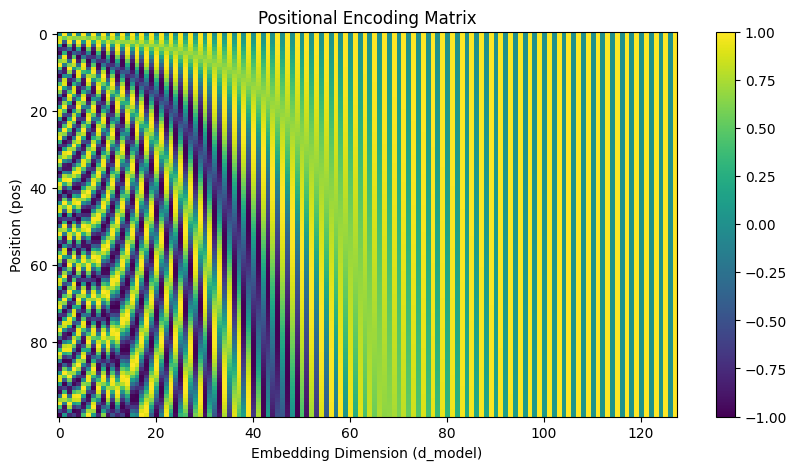

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        """
        Args:
            d_model (int): The embedding dimension.
            max_len (int): The max sequence length to pre-compute.
            dropout (float): Dropout probability.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a positional encoding matrix
        pe = torch.zeros(max_len, d_model)

        # position (0, 1, 2, ..., max_len-1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # [max_len, 1]

        # 1 / (10000^(2i/d_model))
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term) # Even
        pe[:, 1::2] = torch.cos(position * div_term) # Odd

        # Add a batch dimension
        # (max_len, d_model) -> (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Register as a buffer. This tensor is part of the model's state,
        # but it is NOT a parameter to be trained by the optimizer.
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (Tensor): The input embeddings, shape [batch_size, seq_len, d_model]
        """
        # Add the positional encoding to the input
        # self.pe is (1, max_len, d_model). We slice it to (1, seq_len, d_model)
        # This (1, seq_len, d_model) is broadcasted across the batch dimension.
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- Let's visualize the Positional Encodings ---

d_model = 128
max_len = 100

pe_module = PositionalEncoding(d_model, max_len)
pe_matrix = pe_module.pe.squeeze(0).numpy() # Get the (max_len, d_model) matrix

plt.figure(figsize=(10, 5))
plt.imshow(pe_matrix, cmap='viridis', aspect='auto')
plt.xlabel("Embedding Dimension (d_model)")
plt.ylabel("Position (pos)")
plt.title("Positional Encoding Matrix")
plt.colorbar()
plt.show()

# The y-axis (Position) shows the unique vector for each word.
# The x-axis (Dimension) shows the sin/cos waves.

## 3. Building the Encoder

As we learned in the last notebook, the Encoder is just a stack of `N` identical **Encoder Blocks**.

The full `Encoder` module needs to do two things:
1.  Take the input token indices and get their embeddings.
2.  Add the Positional Encodings.
3.  Pass this combined tensor through the stack of `N` Encoder Blocks.

First, let's paste our code for the `MultiHeadAttention`, `PositionWiseFeedForward`, and `EncoderBlock` from the previous notebook.

In [4]:
# --- Scaled Dot-Product Attention (for use in MHA) ---
def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, value)
    return output, attn_weights

# --- Multi-Head Attention ---
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h):
        super().__init__()
        assert d_model % h == 0
        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.h, self.d_k)
        return x.transpose(1, 2)

    def forward(self, query_in, key_in, value_in, mask=None):
        batch_size = query_in.size(0)

        Q = self.split_heads(self.W_q(query_in), batch_size)
        K = self.split_heads(self.W_k(key_in), batch_size)
        V = self.split_heads(self.W_v(value_in), batch_size)

        context, attn_weights = scaled_dot_product_attention(Q, K, V, mask)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context)

# --- Position-wise Feed-Forward Network ---
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, d_model, h, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, h)
        self.ffn = PositionWiseFeedForward(d_model, d_ff)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # MHA Sub-layer
        attn_output = self.mha(x, x, x, mask)
        # Add & Norm
        x = self.layernorm1(x + self.dropout1(attn_output))

        # FFN Sub-layer
        ffn_output = self.ffn(x)
        # Add & Norm
        output = self.layernorm2(x + self.dropout2(ffn_output))

        return output

Now, we can build the full `Encoder` wrapper.

In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, h, d_ff, max_len=5000, dropout=0.1):
        """
        Args:
            vocab_size (int): Size of the source vocabulary.
            d_model (int): Embedding dimension.
            n_layers (int): Number of EncoderBlocks to stack (N in the paper).
            h (int): Number of attention heads.
            d_ff (int): Hidden dimension of the FFN.
        """
        super().__init__()
        self.d_model = d_model

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        # Create a list of N EncoderBlocks
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, h, d_ff, dropout) for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: [batch_size, src_len]
        # mask shape: [batch_size, 1, 1, src_len] (padding mask)

        # 1. Get Embeddings
        # (We multiply by sqrt(d_model) as done in the paper)
        x = self.embedding(x) * math.sqrt(self.d_model)

        # 2. Add Positional Encoding
        x = self.pos_encoding(x)

        # 3. Pass through N EncoderBlocks
        for layer in self.layers:
            x = layer(x, mask)

        return x # Final output shape: [batch_size, src_len, d_model]

## 4. Building the Decoder

The Decoder is conceptually similar: it's a stack of `N` identical **Decoder Blocks**.

However, the `DecoderBlock` is more complex than the `EncoderBlock`. It has **three** sub-layers, not two:

1.  **Masked Multi-Head Attention:** This is a self-attention layer for the *target* (decoder) sequence. It has one crucial difference: it must be **masked** to prevent it from "looking ahead" at future tokens. When translating, we can't know what word 3 is when we are predicting word 2.
2.  **Encoder-Decoder Attention:** This is the most important layer. It's an MHA layer where the **Query (Q)** comes from the previous decoder layer, but the **Key (K)** and **Value (V)** come from the **output of the Encoder**. This is where the decoder "looks at" the source sentence to decide what to translate.
3.  **Feed-Forward Network:** Same as the encoder.

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, h, d_ff, dropout=0.1):
        super().__init__()

        # 1. Masked MHA
        self.masked_mha = MultiHeadAttention(d_model, h)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        # 2. Encoder-Decoder MHA
        self.enc_dec_mha = MultiHeadAttention(d_model, h)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

        # 3. FFN
        self.ffn = PositionWiseFeedForward(d_model, d_ff)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_outputs, src_mask, trg_look_ahead_mask):
        """
        Args:
            x (Tensor): Target sequence, [batch_size, trg_len, d_model]
            encoder_outputs (Tensor): Output from Encoder, [batch_size, src_len, d_model]
            src_mask (Tensor): Padding mask for source seq, [batch_size, 1, 1, src_len]
            trg_look_ahead_mask (Tensor): Look-ahead + padding mask for target seq, [batch_size, 1, trg_len, trg_len]
        """

        # 1. Masked MHA (Self-Attention)
        # Q=x, K=x, V=x
        # We use the trg_look_ahead_mask to hide future tokens
        attn1_output = self.masked_mha(x, x, x, trg_look_ahead_mask)
        x = self.layernorm1(x + self.dropout1(attn1_output))

        # 2. Encoder-Decoder MHA
        # Q=x (from previous layer), K=encoder_outputs, V=encoder_outputs
        # We use the src_mask to hide padding in the encoder_outputs
        attn2_output = self.enc_dec_mha(x, encoder_outputs, encoder_outputs, src_mask)
        x = self.layernorm2(x + self.dropout2(attn2_output))

        # 3. FFN
        ffn_output = self.ffn(x)
        output = self.layernorm3(x + self.dropout3(ffn_output))

        return output

Now, we build the full `Decoder` wrapper. It's similar to the `Encoder`, but it also has a final `nn.Linear` layer to project the `d_model` output to the size of our target vocabulary.

In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, h, d_ff, max_len=5000, dropout=0.1):
        """
        Args:
            vocab_size (int): Size of the target vocabulary.
            d_model (int): Embedding dimension.
            n_layers (int): Number of DecoderBlocks to stack.
            h (int): Number of attention heads.
            d_ff (int): Hidden dimension of the FFN.
        """
        super().__init__()
        self.d_model = d_model

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        self.layers = nn.ModuleList([
            DecoderBlock(d_model, h, d_ff, dropout) for _ in range(n_layers)
        ])

        # Final linear layer to get logits
        self.fc_out = nn.Linear(d_model, vocab_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_outputs, src_mask, trg_mask):
        # x shape: [batch_size, trg_len]
        # encoder_outputs shape: [batch_size, src_len, d_model]
        # src_mask shape: [batch_size, 1, 1, src_len]
        # trg_mask shape: [batch_size, 1, trg_len, trg_len]

        # 1. Get Embeddings and scale
        x = self.embedding(x) * math.sqrt(self.d_model)

        # 2. Add Positional Encoding
        x = self.pos_encoding(x) # [batch_size, trg_len, d_model]

        # 3. Pass through N DecoderBlocks
        for layer in self.layers:
            x = layer(x, encoder_outputs, src_mask, trg_mask)

        # 4. Pass through final linear layer
        output = self.fc_out(x)

        return output # [batch_size, trg_len, target_vocab_size]

## 5. The Transformer (The Final Wrapper)

We're almost there! The final `Transformer` model ties everything together. It contains:
1.  An `Encoder` instance.
2.  A `Decoder` instance.

Its main job is to **create the masks** and pass them to the `Encoder` and `Decoder`.

**Masking is CRITICAL:**
1.  **Padding Mask (`src_mask`, `trg_padding_mask`):**
    * This mask is used to tell the model to **ignore** `<pad>` tokens.
    * It finds all `<pad>` tokens in the input and creates a boolean mask.
    * Shape: `[batch_size, 1, 1, src_len]` (for `src`) or `[batch_size, 1, 1, trg_len]` (for `trg`).
2.  **Look-Ahead Mask (`trg_look_ahead_mask`):**
    * This mask is used *only* in the decoder's *self-attention* layer.
    * It prevents a position from attending to *future* positions.
    * It's a lower-triangular matrix.
    * Shape: `[trg_len, trg_len]`
3.  **Final Target Mask (`trg_mask`):**
    * This is a combination of the `trg_padding_mask` and the `trg_look_ahead_mask`. It hides *both* padding and future tokens.
    * Shape: `[batch_size, 1, trg_len, trg_len]`

In [8]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def create_padding_mask(self, seq, pad_idx):
        """
        Creates a mask for padding tokens.
        Shape: [batch_size, seq_len] -> [batch_size, 1, 1, seq_len]
        """
        mask = (seq != pad_idx).unsqueeze(1).unsqueeze(2)
        # (batch_size, 1, 1, seq_len)
        return mask

    def create_look_ahead_mask(self, seq_len):
        """
        Creates a look-ahead mask for the decoder.
        Shape: (seq_len, seq_len)
        """
        # torch.tril creates a lower-triangular matrix
        mask = torch.tril(torch.ones((seq_len, seq_len), device=self.device)).bool()
        return mask # [seq_len, seq_len]

    def forward(self, src, trg):
        # src shape: [batch_size, src_len]
        # trg shape: [batch_size, trg_len]

        # 1. Create Masks
        src_mask = self.create_padding_mask(src, self.src_pad_idx)

        trg_padding_mask = self.create_padding_mask(trg, self.trg_pad_idx)
        # trg_padding_mask shape: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]
        trg_look_ahead_mask = self.create_look_ahead_mask(trg_len)
        # trg_look_ahead_mask shape: [trg_len, trg_len]

        # Combine padding and look-ahead masks for the target
        # [batch_size, 1, 1, trg_len] & [trg_len, trg_len]
        trg_mask = trg_padding_mask & trg_look_ahead_mask
        # trg_mask shape: [batch_size, 1, trg_len, trg_len]

        # 2. Run Encoder
        encoder_outputs = self.encoder(src, src_mask)
        # encoder_outputs shape: [batch_size, src_len, d_model]

        # 3. Run Decoder
        output = self.decoder(trg, encoder_outputs, src_mask, trg_mask)
        # output shape: [batch_size, trg_len, target_vocab_size]

        return output

## 6. Data Preparation (Identical to Part 1 & 2)

This section is identical to our previous notebooks. We'll load the data, build vocabularies, and create our DataLoaders. We'll paste it all in one cell.

In [9]:
# --- Download and Load Data ---
!wget -q https://www.manythings.org/anki/fra-eng.zip
!unzip -q fra-eng.zip
DATA_PATH = 'fra.txt'

# --- Load Spacy Tokenizers ---
spacy_en = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')

# --- Vocabulary Class ---
class Vocabulary:
    def __init__(self, tokenizer, min_freq=2):
        self.tokenizer = tokenizer
        self.min_freq = min_freq
        self.itos = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.stoi = {v: k for k, v in self.itos.items()}

    def build_vocabulary(self, sentence_list):
        word_counts = Counter()
        for sentence in sentence_list:
            tokens = [token.text.lower() for token in self.tokenizer(sentence)]
            word_counts.update(tokens)
        words = [word for word, count in word_counts.items() if count >= self.min_freq]
        idx = len(self.itos)
        for word in words:
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1

    def numericalize(self, text):
        tokens = [token.text.lower() for token in self.tokenizer(text)]
        return [self.stoi.get(token, self.stoi['<unk>']) for token in tokens]

# --- Load, Tokenize, and Build Vocab ---
pairs = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            pairs.append((parts[0], parts[1]))

pairs = pairs[:30000] # Use 30k examples
source_sentences = [pair[0] for pair in pairs]
target_sentences = [pair[1] for pair in pairs]

en_vocab = Vocabulary(spacy_en.tokenizer)
fr_vocab = Vocabulary(spacy_fr.tokenizer)
en_vocab.build_vocabulary(source_sentences)
fr_vocab.build_vocabulary(target_sentences)

print(f"EN Vocab Size: {len(en_vocab.itos)}")
print(f"FR Vocab Size: {len(fr_vocab.itos)}")

# --- Special Token Indices ---
SRC_PAD_IDX = en_vocab.stoi['<pad>']
TRG_PAD_IDX = fr_vocab.stoi['<pad>']
TRG_SOS_IDX = fr_vocab.stoi['<sos>']

# --- Dataset and Collate Function ---
class TranslationDataset(data.Dataset):
    def __init__(self, source_sentences, target_sentences, en_vocab, fr_vocab):
        self.source_data = []
        self.target_data = []
        for i in range(len(source_sentences)):
            # We DON'T add <sos> or <eos> to the source
            src = en_vocab.numericalize(source_sentences[i])

            # We DO add <sos> and <eos> to the target
            trg = [TRG_SOS_IDX] + fr_vocab.numericalize(target_sentences[i]) + [fr_vocab.stoi['<eos>']]

            self.source_data.append(torch.tensor(src))
            self.target_data.append(torch.tensor(trg))
    def __len__(self):
        return len(self.source_data)
    def __getitem__(self, idx):
        return self.source_data[idx], self.target_data[idx]

def collate_batch(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=SRC_PAD_IDX)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=TRG_PAD_IDX)
    return src_padded, trg_padded

# --- Create DataLoaders ---
total_size = len(pairs)
train_size = int(total_size * 0.9)
val_size = total_size - train_size
train_pairs, val_pairs = data.random_split(pairs, [train_size, val_size])

train_src = [pair[0] for pair in train_pairs]
train_trg = [pair[1] for pair in train_pairs]
val_src = [pair[0] for pair in val_pairs]
val_trg = [pair[1] for pair in val_pairs]

train_dataset = TranslationDataset(train_src, train_trg, en_vocab, fr_vocab)
val_dataset = TranslationDataset(val_src, val_trg, en_vocab, fr_vocab)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("Data preparation complete.")

EN Vocab Size: 3044
FR Vocab Size: 4604
Data preparation complete.


## 7. Training the Model

We're ready! Let's instantiate our model and define the training loops.

**Hyperparameters:** We'll use a *small* Transformer to ensure it trains quickly on a T4 GPU. The "base" model from the paper is much larger (`d_model=512`, `d_ff=2048`, `N=6`, `H=8`).

**The Training Loop:** This is slightly different from our RNN loop. During training, we feed the *entire* target sequence (e.g., `[<sos>, "bonjour", "comment", "allez", "vous", "?", <eos>]`) into the decoder at once.

The **look-ahead mask** ensures that when predicting "comment" (position 2), the model *only* has access to `<sos>` and "bonjour" (positions 0 and 1). This "masked" self-attention is what allows for efficient, parallel training.

In [16]:
# --- Hyperparameters ---
SRC_VOCAB_SIZE = len(en_vocab.itos)
TRG_VOCAB_SIZE = len(fr_vocab.itos)
D_MODEL = 256
N_LAYERS = 4  # Stack 3 blocks
H = 8         # 8 heads
D_FF = 512    # Feed-forward hidden dim
DROPOUT = 0.1
MAX_LEN = 100 # Max sentence length for PE

# --- Instantiate Model ---
encoder = Encoder(SRC_VOCAB_SIZE, D_MODEL, N_LAYERS, H, D_FF, MAX_LEN, DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, D_MODEL, N_LAYERS, H, D_FF, MAX_LEN, DROPOUT).to(device)

model = Transformer(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

# --- Optimizer and Loss ---
# Adam with custom learning rate is common, but basic Adam works fine
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# --- Training Loop ---
def train_fn(model, loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(loader):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        # The target sequence for the decoder input is
        # all tokens *except* the last one (<eos>)
        trg_input = trg[:, :-1]

        # The target sequence for the loss is
        # all tokens *except* the first one (<sos>)
        trg_target = trg[:, 1:]

        # The model's forward pass handles mask creation
        output = model(src, trg_input)

        # output shape: [batch_size, trg_len-1, trg_vocab_size]
        # trg_target shape: [batch_size, trg_len-1]

        # Reshape for loss function
        output_flat = output.contiguous().view(-1, output.shape[-1])
        trg_target_flat = trg_target.contiguous().view(-1)

        loss = criterion(output_flat, trg_target_flat)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def evaluate_fn(model, loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(loader):
            src = src.to(device)
            trg = trg.to(device)

            trg_input = trg[:, :-1]
            trg_target = trg[:, 1:]

            output = model(src, trg_input)

            output_flat = output.contiguous().view(-1, output.shape[-1])
            trg_target_flat = trg_target.contiguous().view(-1)

            loss = criterion(output_flat, trg_target_flat)
            epoch_loss += loss.item()

    return epoch_loss / len(loader)

# --- Let's Train! ---
N_EPOCHS = 15
CLIP = 1.0
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_fn(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate_fn(model, val_loader, criterion)

    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) % 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-transformer-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 7s
	Train Loss: 3.209 | Train PPL:  24.743
	 Val. Loss: 2.284 |  Val. PPL:   9.816
Epoch: 02 | Time: 0m 7s
	Train Loss: 2.009 | Train PPL:   7.459
	 Val. Loss: 1.767 |  Val. PPL:   5.854
Epoch: 03 | Time: 0m 7s
	Train Loss: 1.520 | Train PPL:   4.570
	 Val. Loss: 1.471 |  Val. PPL:   4.355
Epoch: 04 | Time: 0m 7s
	Train Loss: 1.198 | Train PPL:   3.312
	 Val. Loss: 1.282 |  Val. PPL:   3.603
Epoch: 05 | Time: 0m 7s
	Train Loss: 0.962 | Train PPL:   2.617
	 Val. Loss: 1.189 |  Val. PPL:   3.285
Epoch: 06 | Time: 0m 7s
	Train Loss: 0.795 | Train PPL:   2.215
	 Val. Loss: 1.110 |  Val. PPL:   3.036
Epoch: 07 | Time: 0m 7s
	Train Loss: 0.673 | Train PPL:   1.959
	 Val. Loss: 1.081 |  Val. PPL:   2.947
Epoch: 08 | Time: 0m 7s
	Train Loss: 0.588 | Train PPL:   1.801
	 Val. Loss: 1.048 |  Val. PPL:   2.852
Epoch: 09 | Time: 0m 8s
	Train Loss: 0.524 | Train PPL:   1.689
	 Val. Loss: 1.053 |  Val. PPL:   2.867
Epoch: 10 | Time: 0m 7s
	Train Loss: 0.479 | Train PPL:   1.615


## 8. Inference

Inference with a Transformer is **different** and **slower** than training. We can't process the whole target sequence in parallel because we haven't generated it yet!

We must use an **auto-regressive** process:
1.  Run the `Encoder` **once** and save its output (`encoder_outputs`). This is our "context."
2.  Start the decoder with just the `<sos>` token.
3.  Enter a loop:
    a. Pass the *current* output sequence (e.g., `[<sos>]`) and the `encoder_outputs` to the `Decoder`.
    b. Get the logits for the *very last* token.
    c. Apply `argmax` to get the predicted word index.
    d. Append this new word index to our output sequence.
    e. If the new word is `<eos>`, stop.
    f. Repeat the loop with the *new* output sequence (e.g., `[<sos>, "bonjour"]`).

This is sequential, just like an RNN, which is why Transformer *inference* is much slower than its parallel *training*.

In [19]:
# Load our best saved model
model.load_state_dict(torch.load('best-transformer-model.pt'))

def translate_sentence(sentence, model, en_vocab, fr_vocab, device, max_len=50):
    model.eval()

    # 1. Tokenize and numericalize source
    tokens = [token.text.lower() for token in spacy_en.tokenizer(sentence)]
    src_indices = en_vocab.numericalize(sentence)
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)

    # 2. Create source padding mask
    src_mask = model.create_padding_mask(src_tensor, SRC_PAD_IDX)

    # 3. Run Encoder ONCE
    with torch.no_grad():
        encoder_outputs = model.encoder(src_tensor, src_mask)

    # 4. Start Decoder with <sos> token
    trg_indices = [TRG_SOS_IDX]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)

        # 5. Create target mask
        # This will be a combined padding + look-ahead mask
        # for the *current* sequence
        trg_mask = model.create_padding_mask(trg_tensor, TRG_PAD_IDX)
        trg_len = trg_tensor.shape[1]
        trg_look_ahead_mask = model.create_look_ahead_mask(trg_len)
        final_trg_mask = trg_mask & trg_look_ahead_mask

        # 6. Run Decoder
        with torch.no_grad():
            output = model.decoder(trg_tensor, encoder_outputs, src_mask, final_trg_mask)

        # 7. Get the prediction for the *last* token
        pred_token = output.argmax(2)[:, -1].item()

        # 8. Append to output sequence
        trg_indices.append(pred_token)

        # 9. Stop if <eos>
        if pred_token == fr_vocab.stoi['<eos>']:
            break

    # Convert indices back to words
    trg_tokens = [fr_vocab.itos[i] for i in trg_indices]

    # Return the translation (skipping <sos>)
    return " ".join(trg_tokens[1:])

# --- Let's try some examples! ---

# Pick a random sentence from the validation set
example_idx = 10
src_sentence = val_src[example_idx]
trg_sentence = val_trg[example_idx]

translation = translate_sentence(src_sentence, model, en_vocab, fr_vocab, device)

print(f"Source (EN): {src_sentence}")
print(f"Target (FR): {trg_sentence}")
print(f"Model (PRED): {translation}")
print("---")

# Try a custom sentence
custom_sentence = "A man is reading a book."
translation = translate_sentence(custom_sentence, model, en_vocab, fr_vocab, device)

print(f"Source (EN): {custom_sentence}")
print(f"Model (PRED): {translation}")

Source (EN): You're my hero.
Target (FR): Vous êtes mon héroïne.
Model (PRED): vous êtes mon héros . <eos>
---
Source (EN): A man is reading a book.
Model (PRED): l' homme est en livre . <eos>


## 9. Conclusion and Next Steps

We have just built, from scratch, one of the most important deep learning architectures ever created.

We've seen:
* How to use **Positional Encodings** to give the model a sense of order.
* How the **Encoder** uses MHA to build a rich representation of the input.
* How the **Decoder** uses two types of attention (Masked MHA and Encoder-Decoder MHA) to generate a translation.
* How **masking** is the critical "glue" that allows for parallel training by hiding padding and future tokens.
* How **inference** works as a sequential, auto-regressive process.

**Where to go from here?**
We are now at the gateway of modern NLP. The concepts we've learned are the direct foundation for:
* **BERT (Bidirectional Encoder Representations from Transformers):** What if we just take the **Encoder** part, stack it high (12 or 24 layers), and pre-train it on a massive amount of text (like all of Wikipedia)?
* **GPT (Generative Pre-trained Transformer):** What if we just take the **Decoder** part, stack it high, and pre-train it to predict the next word?
* **Pre-training and Fine-tuning:** The dominant paradigm in NLP today, which all started with this architecture.